In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
from tensorflow.keras import layers

## Data import

In [8]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data['lpk'] = data['lpk'].apply(str)

In [9]:
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,721,G2,13,8.20
1,C,1_49,F,40-49,334,G2,0,2.51
2,M,50_249,F,40-49,522,G2,18,2.19
3,M,50_249,F,40-49,522,G2,12,2.19
4,M,50_249,F,14-29,522,G2,0,2.19


## Spliting of dataframes for training, validation and testing

In [10]:
train, val, test = np.split(data.sample(frac=1), [int(0.7*len(data)), int(0.8*len(data))])
print(train.shape, val.shape, test.shape)

(22850, 8) (3264, 8) (6529, 8)


## Preprocessing functions
Based on: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

### Normalization of numeric features

In [12]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Encoding of string features

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

## Preprocessing

In [14]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [15]:
all_inputs = []
encoded_features = []

In [16]:
# Numerical features.
for header in ['experience']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
categorical_cols = ['nace', 'esize_class', 'gender', 'age_class', 'education', 'lpk']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Model and predictions

In [18]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [19]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10*1000,
  decay_rate=1,
  staircase=False)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [20]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

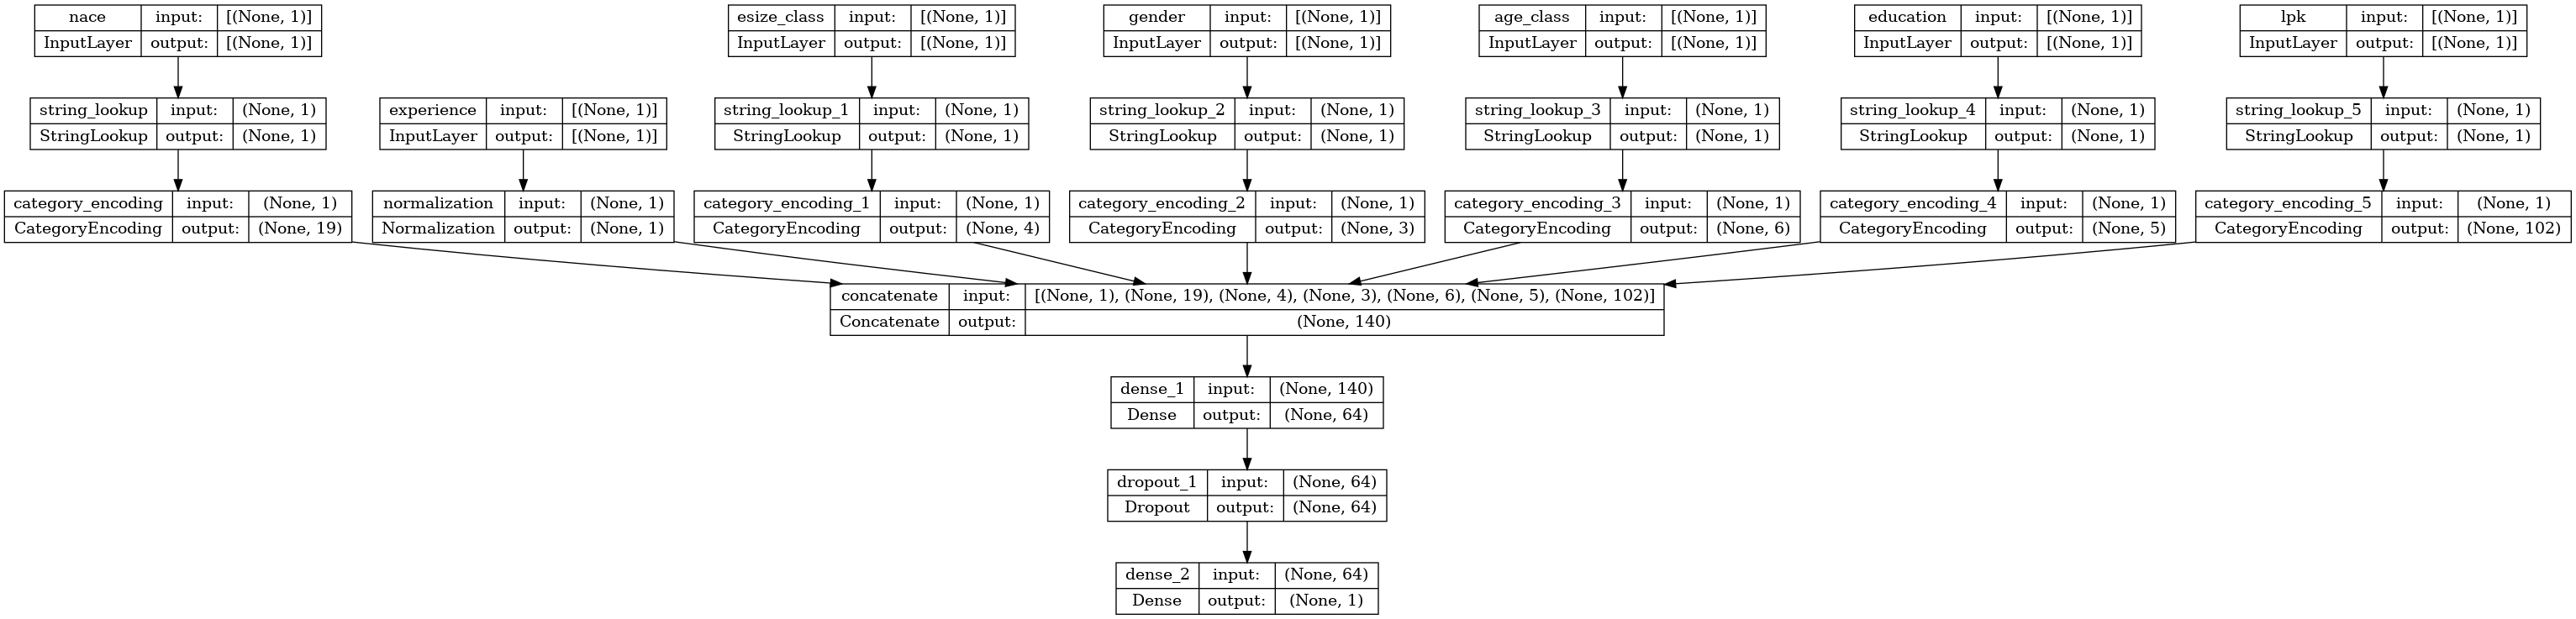

In [22]:
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True)

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=30, 
    restore_best_weights=True,
)

In [24]:
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping, tensorboard_callback, lr_callback],
    verbose=0)

Minimum validation RMSE: 1.6736650466918945


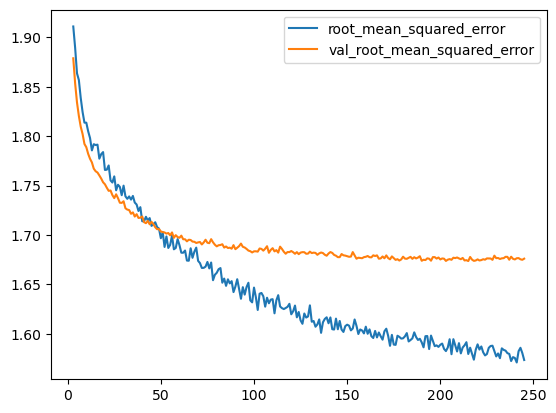

In [25]:
history_df = pd.DataFrame(history.history)
history_df.loc[3:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation RMSE: {}".format(history_df['val_root_mean_squared_error'].min()))

In [26]:
loss, rmse = model.evaluate(test_ds)

26/26 [==============================] - 0s 1ms/step - loss: 2.7434 - root_mean_squared_error: 1.6563


In [28]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/scalars